In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [2]:
user_data = pd.read_csv("./data_result/user_data.csv")
item_data = pd.read_csv("./data_result/item_data.csv")
data_train = pd.read_csv("./data_result/data_train.csv")
data_eval = pd.read_csv("./data_result/data_eval.csv")
data_test = pd.read_csv("./data_result/data_test.csv")


In [3]:
print(user_data.shape)

print(data_train.shape)
print(data_test.shape)

(23291027, 6)
(8324819, 19)
(8858710, 19)


In [4]:
# 划分数据集  predict_date:预测日期
def split_x_y(data, predict_date):
    end_date = "2014-12-1" + str(int(predict_date[-1])+1)
    #在此时间段购买商品的标签
    labels = user_data[(user_data["time"] >= predict_date)&(user_data["time"] < end_date)&(user_data["behavior_type"] == 4)][["user_id", "item_id"]].drop_duplicates()
    labels["is_buy"] = 1
    data = pd.merge(data, labels, how="left", on=["user_id", "item_id"])
    data["is_buy"] = data["is_buy"].fillna(0)
    x_train = data.drop(["user_id", "item_id", "item_category", "is_buy"], axis=1)
   
    y_train = data["is_buy"]
    print(end_date)
    print(labels)
    return (x_train, y_train)     

In [5]:
# 训练集
(x_train,y_train) = split_x_y(data_train, "2014-12-17")
# 验证集
(x_eval,y_eval) = split_x_y(data_eval, "2014-12-18")
# 测试集 data_test
print(x_train.shape)
print(x_eval.shape)

2014-12-18
            user_id    item_id  is_buy
5357       10011993   35096600       1
8384      100135783  240901487       1
18762     100226515  260210381       1
28877     100442521  350540456       1
30138     100475890  321002841       1
31401     100498063  352768418       1
31839      10051209   73132337       1
35872     100586848   33846695       1
37124     100586848   83477536       1
42364     100639219  290304707       1
48649     100764094  350345048       1
48691     100764094  152338475       1
49696     100764094   59347688       1
49849     100764094  162928258       1
49990     100764094   86847204       1
55727        100890  173525858       1
55728        100890   89313832       1
67387     100962079   65706840       1
68578     100973683  393315679       1
68773     100973683   76859443       1
80052     101266396  208699554       1
82812     101366281  184994538       1
83525     101380978   47210838       1
83556     101380978  337403579       1
84283     1014

In [6]:
 print(x_train.head())

   user_item_look_counts  user_item_buy_counts  item_look_counts_before_buy  \
0                    1.0                   0.0                          NaN   
1                    2.0                   0.0                          NaN   
2                    5.0                   1.0                          3.0   
3                    3.0                   0.0                          NaN   
4                    2.0                   0.0                          NaN   

   earliest_user_item_timedelta_look_to_buy  user_category_look_counts  \
0                                       NaN                        1.0   
1                                       NaN                        6.0   
2                                      0.03                        7.0   
3                                       NaN                       19.0   
4                                       NaN                        6.0   

   user_category_buy_counts  category_look_counts_before_buy  \
0               

In [7]:
 print(y_train.value_counts())

0.0    8322828
1.0       1991
Name: is_buy, dtype: int64


In [8]:
import xgboost as xgb
xgb_train = xgb.DMatrix(x_train,y_train)
xgb_eval = xgb.DMatrix(x_eval,y_eval)
xbg_test = xgb.DMatrix(data_test.drop(["user_id", "item_id", "item_category"], axis=1))

In [9]:
params = {
    'objective': 'rank:pairwise', # 学习目标
    'eval_metric': 'auc', # 评价指标
    'gamma': 0.1, # 最小损失函数下降值
    'min_child_weight': 1.1, # 子集观察值的最小权重和
    'max_depth': 6, # 树的最大深度
    'lambda': 10, # L2正则化项
    'subsample': 0.7, # 树采样率
    'colsample_bytree': 0.7, # 特征采样率
    'eta': 0.01, # 学习率
    'tree_method':'exact', # 算法类别
    'seed':0
}

In [10]:
import time
a=time.time()
watchlist = [(xgb_train,'train'),(xgb_eval,'validate')]
model_xgb = xgb.train(params,xgb_train,num_boost_round=2000,evals=watchlist,early_stopping_rounds=50)
#说明：设置early_stopping_rounds=10，当logloss在10轮迭代之内，都没有提升的话，就stop。
#如果说eval_metric有很多个指标，那就以最后一个指标为准。
print(time.time()-a)

[0]	train-auc:0.929708	validate-auc:0.880568
Multiple eval metrics have been passed: 'validate-auc' will be used for early stopping.

Will train until validate-auc hasn't improved in 50 rounds.
[1]	train-auc:0.942824	validate-auc:0.904791
[2]	train-auc:0.9452	validate-auc:0.913905
[3]	train-auc:0.949815	validate-auc:0.923705
[4]	train-auc:0.951467	validate-auc:0.926913
[5]	train-auc:0.952179	validate-auc:0.929498
[6]	train-auc:0.954761	validate-auc:0.933936
[7]	train-auc:0.954478	validate-auc:0.933783
[8]	train-auc:0.954214	validate-auc:0.933972
[9]	train-auc:0.953595	validate-auc:0.933187
[10]	train-auc:0.953706	validate-auc:0.933217
[11]	train-auc:0.95412	validate-auc:0.933703
[12]	train-auc:0.954506	validate-auc:0.934537
[13]	train-auc:0.954576	validate-auc:0.93462
[14]	train-auc:0.954781	validate-auc:0.934661
[15]	train-auc:0.955229	validate-auc:0.93625
[16]	train-auc:0.955446	validate-auc:0.936721
[17]	train-auc:0.955209	validate-auc:0.93648
[18]	train-auc:0.955764	validate-auc:0.

In [21]:
model_xgb.save_model('./model/xgb.model')#保存模型

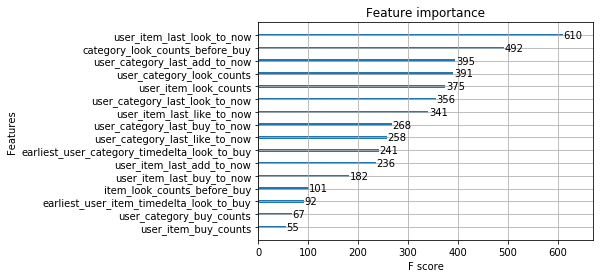

In [22]:
from xgboost import plot_importance
plot_importance(model_xgb)
plt.show()

In [24]:
print(model_xgb.best_iteration)#36/86  
#model_xgb = xgb.train(params,xgb_train,num_boost_round=model_xgb.best_iteration)#最佳迭代次数

36


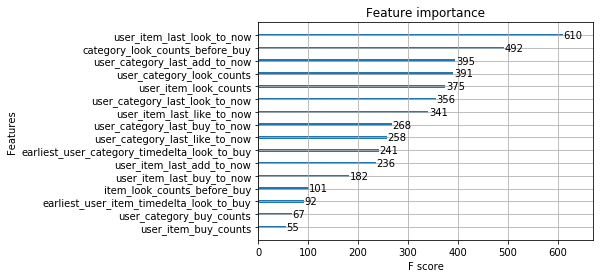

In [14]:
from xgboost import plot_importance
plot_importance(model_xgb)
plt.show()

In [15]:
#model_xgb.save_model('./model/xgb_best_iteration.model')#保存模型

In [25]:
from sklearn.preprocessing import MinMaxScaler
eval_data = user_data[user_data["time"] < "2014-12-18"][["user_id", "item_id", "item_category"]].drop_duplicates()
print(len(eval_data))
eval_data["pred"] = model_xgb.predict(xgb.DMatrix(x_eval))
eval_data["pred"] = MinMaxScaler().fit_transform(eval_data["pred"].values.reshape(-1, 1))

8595453


In [28]:
threshold = eval_data[["pred"]].sort_values(by="pred", ascending=False).iloc[550][0]
y_pred = eval_data["pred"].tolist()
for i in range(len(y_pred)):
    if y_pred[i] >= threshold:
        y_pred[i] = 1
    else:
        y_pred[i] = 0
y_eval = y_eval#.tolist()

In [29]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
print("Validate set accuracy score: {:.4f}".format(accuracy_score(y_pred, y_eval)))
print("Validate set F1 score : {:.4f}".format(f1_score(y_pred, y_eval)))
confusion_matrix(y_pred, y_eval) 

Validate set accuracy score: 0.9997
Validate set F1 score : 0.0574


array([[8592611,    1888],
       [    870,      84]], dtype=int64)

In [30]:
from sklearn.preprocessing import MinMaxScaler
item_list = item_data["item_id"].unique().tolist()
predict = data_test[["user_id", "item_id"]]
predict["label"] = model_xgb.predict(xbg_test)
predict["label"] = MinMaxScaler().fit_transform(predict["label"].values.reshape(-1, 1))
predict = predict[predict["item_id"].isin(item_list)].sort_values(by="label", ascending=False)

In [31]:
result = predict.head(550)[["user_id", "item_id"]].drop_duplicates()
result.to_csv("tianchi_mobile_recommendation_predict.csv", index=False)